In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
#
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
# from collections import namedtuple

try:
    # for Python2
    from Tkinter import *   ## notice capitalized T in Tkinter 
except ImportError:
    # for Python3
    from tkinter import *   ## notice lowercase 't' in tkinter here


In [2]:
def _parse_line(line):
    """
    Do a regex search against all defined regexes and
    return the key and match result of the first matching regex

    """

    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            return key, match
    # if there are no matches
    return None, None

In [3]:
methods=['vecCuckoo', 'ViViD', 'cuckoo']

rx_dict = {
    'build': re.compile(r'(Generation|Cuckoo Table Generation:) (?P<build>.*) ms \n'),
    'probe': re.compile(r'Join core: (?P<probe>\d*) ms \n'),
}

data = []
build = None
probe = None
        
for m in methods:
    for i in range(10, 100, 10):
        with open('/home/flav/Mestrado/MHaJoL/data/out/joins/_'+str(i)+'/'+m+'.out', 'r') as file_object:
            line = file_object.readline()
            while line:
                # at each line check for a match with a regex
                key, match = _parse_line(line)
                
                # extract build time
                if key == 'build':
                    build = match.group('build')
                    build = int(build)

                # extract probe time
                if key == 'probe':
                    probe = match.group('probe')
                    probe = int(probe)

                if (build is not None and probe is not None):
                    # create a dictionary containing this row of data
                    row = {
                        'buildTime': build,
                        'probeTime': probe,
                        'method': m,
                        'selectivity': i
                    }
                    # append the dictionary to the data list
                    data.append(row)
                line = file_object.readline()

            # create a pandas DataFrame from the list of dicts
            df = pd.DataFrame(data)
            # set the School, Grade, and Student number as the index
#             df.set_index(['buildTime', 'probeTime', 'method', 'selectivity'], inplace=True)
#             # consolidate df to remove nans
#             df = df.groupby(level=df.index.names).first()
#             # upgrade Score from float to integer
#             df = df.apply(pd.to_numeric, errors='ignore')
print(df.head(100))


    buildTime     method  probeTime  selectivity
0          76  vecCuckoo          6           10
1          76  vecCuckoo          6           10
2          76  vecCuckoo          6           10
3          76  vecCuckoo          6           10
4          76  vecCuckoo          6           10
5          76  vecCuckoo          6           10
6          76  vecCuckoo          6           10
7          76  vecCuckoo          6           10
8          78  vecCuckoo          6           10
9          78  vecCuckoo          6           10
10         78  vecCuckoo          6           10
11         78  vecCuckoo          6           10
12         78  vecCuckoo          6           10
13         78  vecCuckoo          6           10
14         78  vecCuckoo          6           10
15         78  vecCuckoo          6           10
16         78  vecCuckoo          6           10
17         78  vecCuckoo          6           10
18         76  vecCuckoo          6           10
19         76  vecCu

In [96]:
dfQuantile1 = df.groupby(['method', 'selectivity']).quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear').reset_index()
dfQuantile1 = dfQuantile1.rename(index=str, columns={"buildTime": "first"})
dfQuantile1 = dfQuantile1.drop(columns=['probeTime'])

dfQuantile2 = df.groupby(['method', 'selectivity']).quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear').reset_index()
dfQuantile2 = dfQuantile2.rename(index=str, columns={"buildTime": "third"}).drop(columns=['probeTime'])

dfQuantile = pd.merge(dfQuantile1, dfQuantile2, how='inner', on=['method', 'selectivity'])
dfQuantile['IQR'] = dfQuantile['third'] - dfQuantile['first']

dfAggMedian = df.groupby(['method', 'selectivity'], as_index = False).aggregate(np.median)
dfAggMedian = dfAggMedian.rename(index=str, columns={"buildTime": "median"}).drop(columns=['probeTime'])
dfIQR = pd.merge(dfQuantile, dfAggMedian, how='inner', on=['method', 'selectivity'])
dfIQR = pd.merge(dfIQR, df, how='inner', on=['method', 'selectivity']).drop(columns=['probeTime'])

dfIQR['calc1'] = dfIQR['first'] - (1.5 * dfIQR['IQR'])
dfIQR['calc2'] = dfIQR['third'] - (1.5 * dfIQR['IQR'])

dfIQR['values'] = np.where((dfIQR['buildTime'] < (dfIQR['first'] - (0.5 * dfIQR['IQR']))) | (dfIQR['buildTime'] < (dfIQR['third'] - (0.5 * dfIQR['IQR']))), dfIQR['buildTime'], dfIQR['median'])

dfIQR = dfIQR.drop(columns=['buildTime', 'first', 'third', 'IQR', 'median', 'calc1', 'calc2'])
dfIQR = dfIQR.rename(index=str, columns={"values": "value"})

dfAggAVG = dfIQR.groupby(['method', 'selectivity'], as_index = False).aggregate(['mean','std'])


print(dfAggAVG.head(100))

                            value           
                             mean        std
method    selectivity                       
ViViD     10            74.317822   0.984004
          20            72.068317   1.188934
          30            71.217822   0.971384
          40            70.062376   1.865941
          50            70.330693   1.029567
          60            70.154455   1.269410
          70            69.445545   0.802316
          80            69.353465   0.990947
          90            69.290099   1.066659
cuckoo    10           506.825083  27.071858
          20           507.247525  12.075888
          30           514.980198  13.446636
          40           498.907591   9.559211
          50           497.580858  17.380444
          60           491.369637  12.817513
          70           484.402640  10.780762
          80           480.382838  11.826519
          90           466.811881   9.970279
vecCuckoo 10            75.980100   0.139728
          

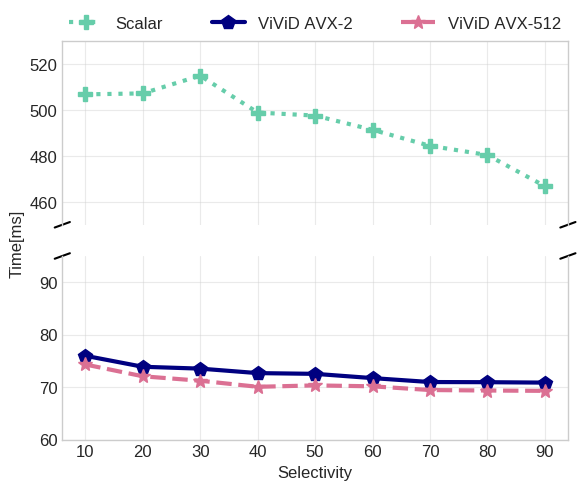

In [97]:
#X axis
n_groups = 9
index = np.arange(n_groups)
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

# NP arrays of values
dfMethodVec = dfAggAVG.xs("vecCuckoo", level='method')['value'].reset_index().sort_values('selectivity')
dfValuesVec = dfMethodVec["mean"]

dfMethod = dfAggAVG.xs("cuckoo", level='method')['value'].reset_index().sort_values('selectivity')
dfValues = dfMethod["mean"]

dfMethodVi = dfAggAVG.xs("ViViD", level='method')['value'].reset_index().sort_values('selectivity')
dfValuesVi = dfMethodVi["mean"]

#Style configs
# plt.style.use('seaborn-whitegrid')

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
ax.grid(alpha=0.4)
ax2.grid(alpha=0.4)

fig.tight_layout()
fig.subplots_adjust(left=0.19, bottom=0.09, right=0.98, top=0.92, wspace=0.17, hspace=0.17)

#Plot
ax.plot(index, dfValues, color='mediumaquamarine', linestyle=':', marker='P', label='Scalar', linewidth=3,markersize=10)
ax.plot(index, dfValuesVec, color='navy', linestyle='-', marker='p', label='ViViD AVX-2', linewidth=3,markersize=10)
ax.plot(index, dfValuesVi, color='palevioletred', linestyle='--', marker='*', label='ViViD AVX-512', linewidth=3,markersize=10)

ax2.plot(index, dfValues, color='mediumaquamarine', linestyle=':', marker='P', label='Scalar', linewidth=3,markersize=10)
ax2.plot(index, dfValuesVec, color='navy', linestyle='-', marker='p', label='ViViD AVX-2', linewidth=3,markersize=10)
ax2.plot(index, dfValuesVi, color='palevioletred', linestyle='--', marker='*', label='ViViD AVX-512', linewidth=3,markersize=10)

#Axis and labels
ax2.set_xlabel('Selectivity')
ax.set_xticklabels(('0', '10', '20', '30', '40', '50', '60', '70', '80', '90'))
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.,fancybox=True)
fig.text(0.12, 0.5, 'Time[ms]', ha='center', va='center', rotation='vertical')

#Break the y axis
ax.set_ylim(450, 530)  # outliers only
ax2.set_ylim(60, 95)  # most of the data

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


plt.rcParams.update({'font.size': 12})

#Draw and save
plt.show()
fig.savefig('/home/flav/Mestrado/MHaJoL/data/out/plots/time.png',  bbox_inches='tight')
fig.clf()


In [98]:
#milion tuples per second

dfIQR['seconds']=dfIQR['value']/1000
dfIQR['tuplesPerSecond']=1500000/dfIQR['seconds']
dfIQR['Mtps']=1.5/dfIQR['seconds']

dfIQR=dfIQR.drop(columns=['seconds', 'tuplesPerSecond', 'value']).rename(index=str, columns={"Mtps": "value"})

dfAggAVGM = dfIQR.groupby(['method', 'selectivity'], as_index = False).aggregate(['mean','std'])

dfAggAVGM.head(100)

value          
                            mean       std
method    selectivity                     
ViViD     10           20.187176  0.271606
          20           20.819328  0.348504
          30           21.066112  0.291235
          40           21.427396  0.676513
          50           21.332471  0.318369
          60           21.388533  0.395035
          70           21.602583  0.253501
          80           21.632832  0.315020
          90           21.653329  0.339057
cuckoo    10            3.014314  1.079467
          20            2.958872  0.073005
          30            2.914769  0.078038
          40            3.007706  0.059414
          50            3.018400  0.109321
          60            3.054849  0.082769
          70            3.098188  0.071542
          80            3.124461  0.079341
          90            3.214797  0.070834
vecCuckoo 10           19.742079  0.036771
          20           20.303261  0.089891
          30           20.401563  0.149744
          40           20.641191  0.133919
          50           20.681936  0.146575
          60           20.915551  0.131842
          70           21.135725  0.051263
          80           21.144690  0.071378
          90           21.168596  0.104340

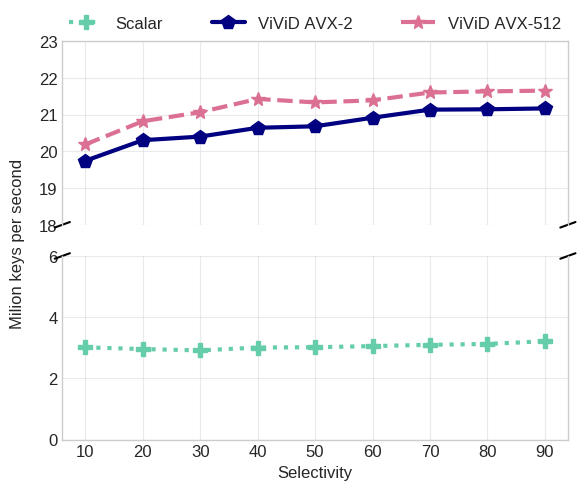

In [103]:
#X axis
n_groups = 9
index = np.arange(n_groups)

# NP arrays of values
dfMethodVec = dfAggAVGM.xs("vecCuckoo", level='method')['value'].reset_index().sort_values('selectivity')
dfValuesVec = dfMethodVec["mean"]

dfMethod = dfAggAVGM.xs("cuckoo", level='method')['value'].reset_index().sort_values('selectivity')
dfValues = dfMethod["mean"]

dfMethodVi = dfAggAVGM.xs("ViViD", level='method')['value'].reset_index().sort_values('selectivity')
dfValuesVi = dfMethodVi["mean"]

#Style configs
# plt.style.use('seaborn-whitegrid')

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
ax.grid(alpha=0.4)
ax2.grid(alpha=0.4)

fig.tight_layout()
fig.subplots_adjust(left=0.19, bottom=0.09, right=0.98, top=0.92, wspace=0.17, hspace=0.17)

#Plot
ax.plot(index, dfValues, color='mediumaquamarine', linestyle=':', marker='P', label='Scalar', linewidth=3,markersize=10)
ax.plot(index, dfValuesVec, color='navy', linestyle='-', marker='p', label='ViViD AVX-2', linewidth=3,markersize=10)
ax.plot(index, dfValuesVi, color='palevioletred', linestyle='--', marker='*', label='ViViD AVX-512', linewidth=3,markersize=10)

ax2.plot(index, dfValues, color='mediumaquamarine', linestyle=':', marker='P', label='Scalar', linewidth=3,markersize=10)
ax2.plot(index, dfValuesVec, color='navy', linestyle='-', marker='p', label='ViViD AVX-2', linewidth=3,markersize=10)
ax2.plot(index, dfValuesVi, color='palevioletred', linestyle='--', marker='*', label='ViViD AVX-512', linewidth=3,markersize=10)

#Axis and labels
ax2.set_xlabel('Selectivity')
ax.set_xticklabels(('0', '10', '20', '30', '40', '50', '60', '70', '80', '90'))
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.,fancybox=True)
fig.text(0.12, 0.5, 'Milion keys per second', ha='center', va='center', rotation='vertical')

#Break the y axis
ax.set_ylim(18, 23)  # outliers only
ax2.set_ylim(0, 6)  # most of the data

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.rcParams.update({'font.size': 12})

#Draw and save
plt.show()
fig.savefig('/home/flav/Mestrado/MHaJoL/data/out/plots/mtps.png',  bbox_inches='tight')
fig.clf()